# Think Bayes

Copyright 2018 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pandas as pd

# import classes from thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint

from thinkbayes2 import MakePoissonPmf, EvalBinomialPmf, MakeMixture

import thinkplot

ERROR:root:The 'ast_node_interactivity' trait of a ZMQInteractiveShell instance must be any of ['all', 'last', 'last_expr', 'none'], but a value of 'last_expr_or_assign' <class 'str'> was specified.


## Lions and Tigers and Bears

Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are.

During the tour, we see 3 lions, 2 tigers and one bear.  Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species.

What is the probability that the next animal we see is a bear?

### Grid algorithm



In [181]:
class LionsTigersBears(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        
        data: string 'L' , 'T', 'B'
        hypo: p1, p2, p3
        """
        p1, p2, p3 = hypo
        
        if data == 'L':
            like = p1
        elif data== 'T':
            like = p2
        elif data == 'B':
            like = p3
        
        return like

In [182]:
ps = np.linspace(0, 1, 101);

In [201]:
from itertools import product
import math 

def enumerate_triples(ps):
#     for p1, p2, p3 in product(ps, ps, ps):
#         if p1+p2+p3 == 1:
#             yield p1, p2, p3

    for p1,p2 in product(ps,ps):
        if p1+p2 >1:
            continue
        yield p1,p2, 1-p1-p2

Write a better version of `enumerate_triples` that doesn't run into problems with floating-point.

In [202]:
# Solution goes here

In [203]:
suite = LionsTigersBears(enumerate_triples(ps));

In [204]:
def plot_marginal_pmfs(joint):
    pmf_lion = joint.Marginal(0)
    pmf_tiger = joint.Marginal(1)
    pmf_bear = joint.Marginal(2)

    thinkplot.Pdf(pmf_lion, label='lions')
    thinkplot.Pdf(pmf_tiger, label='tigers')
    thinkplot.Pdf(pmf_bear, label='bears')
    
#     thinkplot.decorate(xlabel='Prevalence',
#                        ylabel='PMF')

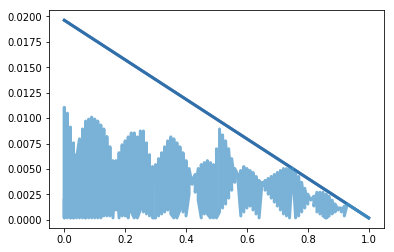

In [205]:
plot_marginal_pmfs(suite)

In [206]:
for data in 'LLLTTB':
    suite.Update(data)

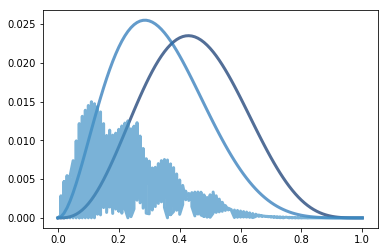

In [207]:
plot_marginal_pmfs(suite)

In [208]:
def plot_marginal_cdfs(joint):
    pmf_lion = joint.Marginal(0)
    pmf_tiger = joint.Marginal(1)
    pmf_bear = joint.Marginal(2)

    thinkplot.Cdf(pmf_lion.MakeCdf(), label='lions')
    thinkplot.Cdf(pmf_tiger.MakeCdf(), label='tigers')
    thinkplot.Cdf(pmf_bear.MakeCdf(), label='bears')
    
#     thinkplot.decorate(xlabel='Prevalence',
#                        ylabel='CDF')

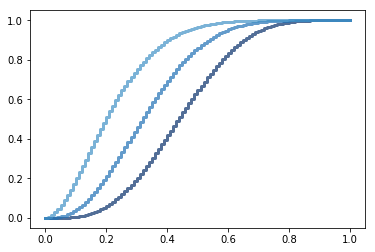

In [209]:
plot_marginal_cdfs(suite)

### Using the Dirichlet object

In [210]:
from thinkbayes2 import Dirichlet

def DirichletMarginal(dirichlet, i):
    return dirichlet.MarginalBeta(i).MakePmf()

Dirichlet.Marginal = DirichletMarginal

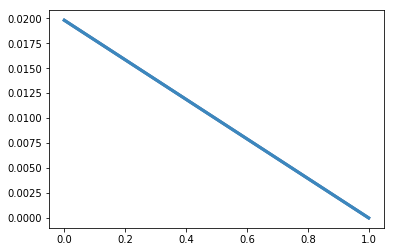

In [211]:
dirichlet = Dirichlet(3)
plot_marginal_pmfs(dirichlet)

In [212]:
dirichlet.Update((3, 2, 1))

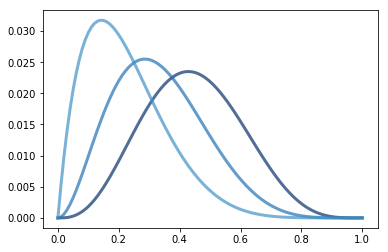

In [213]:
plot_marginal_pmfs(dirichlet)

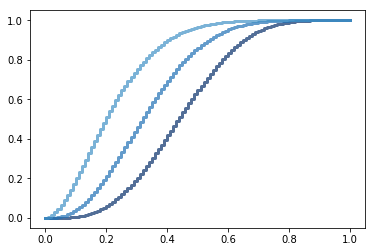

In [214]:
plot_marginal_cdfs(dirichlet)

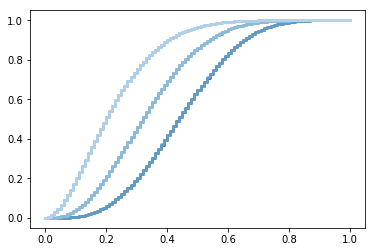

In [215]:
thinkplot.PrePlot(6)
plot_marginal_cdfs(dirichlet)
plot_marginal_cdfs(suite)

### MCMC

Implement this model using MCMC.  You might want to start with [this example](http://christianherta.de/lehre/dataScience/bayesian/Multinomial-Dirichlet.slides.php).

In [254]:
import pymc3 as pm

In [255]:
observed = [0,0,0,1,1,2]
k = len(Pmf(observed))
a = np.ones(k)

In [256]:
model = pm.Model()

with model:
    ps = pm.Dirichlet('ps', a, shape=a.shape)
    xs = pm.Categorical('xs', p, observed=observed, shape=1)

In [257]:
def plot_trace_cdfs(trace):
    rows =trace['ps'].transpose()
    cdf_lion = Cdf(rows[0])
    cdf_tiger = Cdf(rows[1])
    cdf_bear = Cdf(rows[2])

    thinkplot.Cdf(cdf_lion, label='lions')
    thinkplot.Cdf(cdf_tiger, label='tigers')
    thinkplot.Cdf(cdf_bear, label='bears')
    
#     thinkplot.decorate(xlabel='Prevalence',
#                        ylabel='CDF')

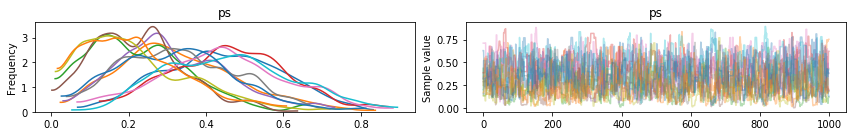

In [258]:
pm.traceplot(trace);

In [244]:
# plot_trace_cdfs(trace['xs'])

In [245]:
# pmf = Pmf(trace['xs'])
# thinkplot.Hist(pmf)

In [252]:
with model:
#     start = pm.find_MAP()
#     step = pm.Metropolis()
# start=start, step=step,
    trace = pm.sample(4000, tune=4000)

TypeError: 'int' object is not iterable

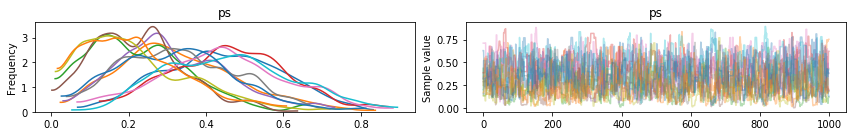

In [259]:
pm.traceplot(trace);

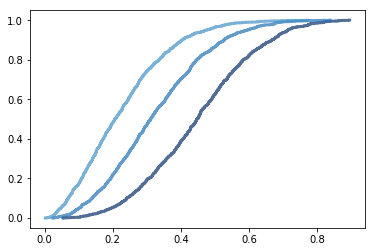

In [260]:
plot_trace_cdfs(trace)

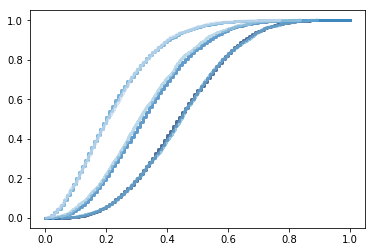

In [225]:
thinkplot.PrePlot(6)
plot_marginal_cdfs(dirichlet)
plot_trace_cdfs(trace)